# ID Cards Visiblity Classification

---

##**Topic:** Classifying the visibility of ID cards in photos.

##**Resources:** You can use any resources to complete this task.

##**Deliverable:** Jupyter notebook or a folder containing all your code and documentation.

##It should explain the steps you’ve taken

###**The Task:** EXPLORATION, ANALYSIS, MODELLING & OPERATIONALIZATION The folder images inside data contains several different types of ID documents taken in 1 different conditions and backgrounds. The goal is to use the images stored in this folder and to design an algorithm that identifies the visibility of the card in the photo (FULL_VISIBILITY, PARTIAL_VISIBILITY, NO_VISIBILITY).

##FULL_VISIBILITY means the card is completely shown; PARTIAL_VISIBILITY means part of the card is clipped; while NO_VISIBILITY means the card does not appear in the image at all.

##We have provided you with the ground truth labels corresponding to each image data in folder data, file gicsd_labels.csv.

## GICSD_{CARD_ID}_{BACKGROUND_ID}_{IMAGE_ID}, and you can use this information to make decisions about your approach if you so desire.

##Unfortunately, the sensor used when taking these photos was damaged and the photos are corrupted, as the images below show:



##GICSD_24_5_153 GICSD_37_5_153 GICSD_50_7_213 It’s up to you to figure out the best way of handling this situation, but to guide you through this challenge you should refer to the following sub-tasks:

##a) Data Exploration

* i) Explore all the available data. What are your preliminary observations?

##b) Feature Engineering

###i) Utilizing some of your findings from part a) create a function that transforms an image (in the format of a numpy array) into a single-channel image.

####Explain the approach used to achieve this.

##c) Model Selection/Validation

###i) Create an ML model which classifies the visibility (FULL_VISIBILITY, PARTIAL_VISIBILITY, NO_VISIBILITY) of the card in the photo. This model must take a single-channel image as input. 

###Justify the choices behind the model and assess the quality of your results.


###ii) Make a train.py module which pulls the raw ids from the CSV and generates the fitted model artifact (it should be stored under the artifacts sub-directory).


##d) Operationalization

###i) Make a predict.py module and write a function that accepts the original RGB (3-channel) images and goes through the Feature Engineering and Inference pipelines to yield the predicted result.

## Import all required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import logging
import skimage
from scipy import ndimage
from skimage import exposure, color
from skimage.transform import resize

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Model
from keras.layers import Concatenate, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from collections import Counter

In [ ]:
#### configuring logging
formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(message)s')
# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

# Add handler
logger = logging.getLogger()
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

##Working directories and read the data

In [ ]:
working_dir = "/content/drive/MyDrive/Lincode"
img_dir = "/content/drive/MyDrive/Lincode/images"
df = pd.read_csv(os.path.join(working_dir,"gicsd_labels.csv"))

## **a) Data Exploration**

---


###i) Explore all the available data.

---



In [ ]:
df.columns = df.columns.str.strip()
df

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY
...,...,...
795,GICSD_50_7_213.png,NO_VISIBILITY
796,GICSD_50_7_233.png,PARTIAL_VISIBILITY
797,GICSD_50_8_253.png,FULL_VISIBILITY
798,GICSD_50_9_273.png,FULL_VISIBILITY


In [ ]:
df.LABEL.value_counts()

 FULL_VISIBILITY        646
 PARTIAL_VISIBILITY     123
 NO_VISIBILITY           31
Name: LABEL, dtype: int64

In [ ]:
df.isnull().sum()

IMAGE_FILENAME    0
LABEL             0
dtype: int64

In [ ]:
df.dtypes

IMAGE_FILENAME    object
LABEL             object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IMAGE_FILENAME  800 non-null    object
 1   LABEL           800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [ ]:
df.describe()

,IMAGE_FILENAME,LABEL
count,800,800
unique,800,3
top,GICSD_1_0_3.png,FULL_VISIBILITY
freq,1,646


#Metadata are included in the image file name column of the dataset in the form 'GICSD_{CARD_ID}_{BACKGROUND_ID}_{IMAGE_ID}'.

In [ ]:
df.LABEL= df.LABEL.str.strip()

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['LABEL'])
logger.debug("encoded classes: %s", list(le.classes_))
df['TARGET'] = le.transform(df['LABEL'])
df['BACKGROUND_ID'] = df['IMAGE_FILENAME'].apply(lambda x: x.split("_")[2]).apply(lambda x: int(x))
df['CARD_ID'] = df['IMAGE_FILENAME'].apply(lambda x: x.split("_")[1]).apply(lambda x: int(x))
df['IMAGE_ID'] = df['IMAGE_FILENAME'].apply(lambda x: x.split("_")[3]).apply(lambda x: x.split(".")[0]).apply(lambda x: int(x))


df

,IMAGE_FILENAME,LABEL,TARGET,BACKGROUND_ID,CARD_ID,IMAGE_ID
0,GICSD_1_0_3.png,FULL_VISIBILITY,0,0,1,3
1,GICSD_1_0_13.png,FULL_VISIBILITY,0,0,1,13
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,2,1,1,33
3,GICSD_1_1_53.png,FULL_VISIBILITY,0,1,1,53
4,GICSD_1_2_73.png,FULL_VISIBILITY,0,2,1,73
...,...,...,...,...,...,...
795,GICSD_50_7_213.png,NO_VISIBILITY,1,7,50,213
796,GICSD_50_7_233.png,PARTIAL_VISIBILITY,2,7,50,233
797,GICSD_50_8_253.png,FULL_VISIBILITY,0,8,50,253
798,GICSD_50_9_273.png,FULL_VISIBILITY,0,9,50,273


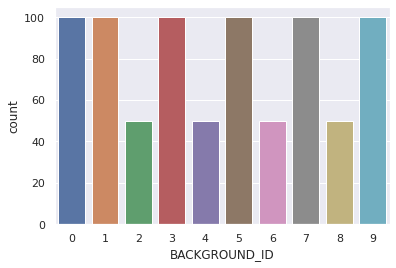

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="BACKGROUND_ID", data=df)

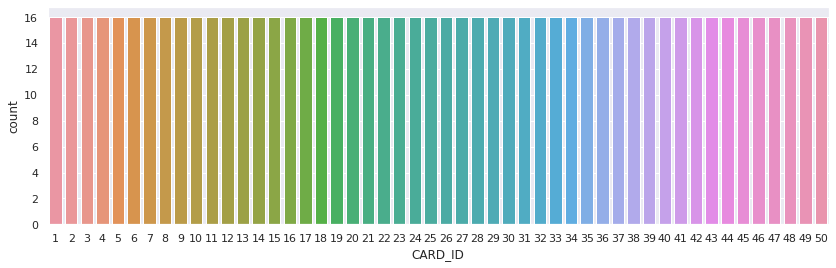

In [ ]:
plt.figure(figsize=(14, 4))
ax = sns.countplot(x="CARD_ID", data=df)

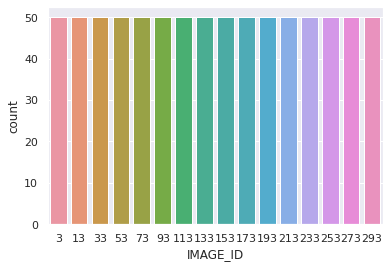

In [ ]:
ax = sns.countplot(x="IMAGE_ID", data=df)

[Text(0, 0, 'Full Visibility'),
 Text(0, 0, 'No Visibility'),
 Text(0, 0, 'Partial Visibility')]

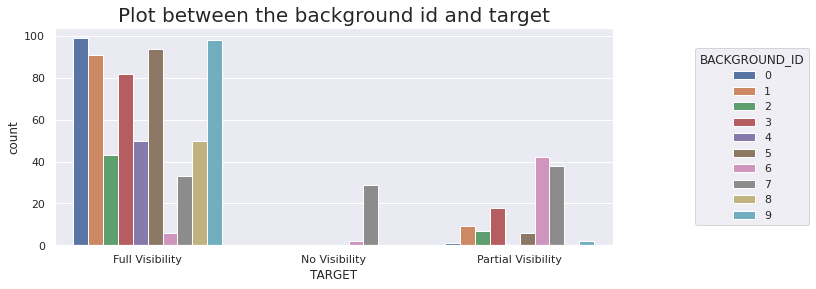

In [ ]:
plt.figure(figsize=(10, 4))
plt.title('Plot between the background id and target', fontsize=20)
ax = sns.countplot(x="TARGET", hue="BACKGROUND_ID", data=df, dodge = True)
ax.legend(loc='center', bbox_to_anchor=(1.25, 0.5), ncol=1, title="BACKGROUND_ID")
ticklabels=['Full Visibility', 'No Visibility', 'Partial Visibility']
ax.xaxis.set_ticklabels(ticklabels)

## Check the images

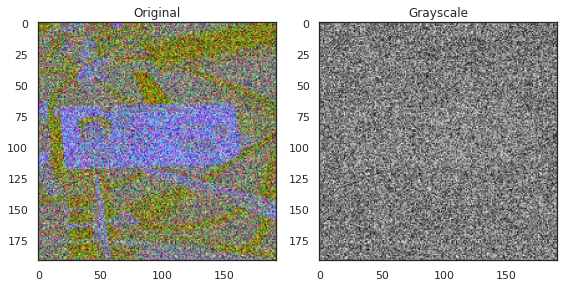

In [ ]:
sns.set(style="white")
img = plt.imread(os.path.join(img_dir, df.IMAGE_FILENAME[0]))
grayscale_img1 = color.rgb2gray(img)

def plot_img1_vs_img2(img1, img2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()
    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(title1)
    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(title2)

    fig.tight_layout()
    plt.show()
    
plot_img1_vs_img2(img, grayscale_img1, "Original", "Grayscale")

Result is simply white noise.


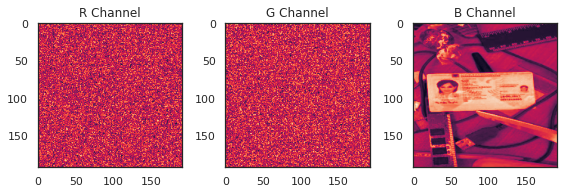

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img[:,:,0])
ax[0].set_title("R Channel")
ax[1].imshow(img[:,:,1])
ax[1].set_title("G Channel")
ax[2].imshow(img[:,:,2])
ax[2].set_title("B Channel")

fig.tight_layout()
plt.show()

##Image in the B channel. Looks better in color.

Text(0.5, 1.0, 'Channel B in Grayscaled Image')

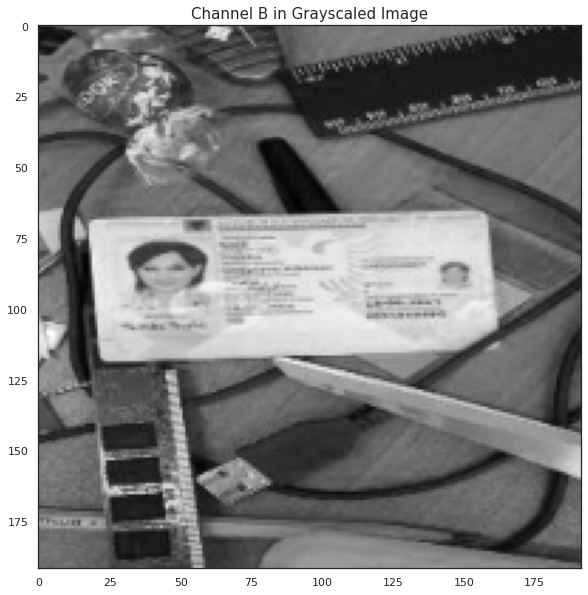

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,2], cmap=plt.cm.gray)
plt.title("Channel B in Grayscaled Image", fontsize=15)

## Whether the actual image is always encoded in the **B** channel we make the following simplifying assumption:

#### The median (absolute) correlation among the rows in the image matrix is going to be maximum in the channel containing structured information.

###If a channel only contains random pixels, the median absolute correlation among the rows in the image matrix should be low. 

###On the other hand, when a channel encodes an actual image, we can expect the presence of some structured information to increase the medain absolute correlation.

###We can use this heuristics to see which channels contain the image we have to classify.

#Preliminary observations

---


##Total of 800 images available in the dataset All images have the same size of 192x192 pixels

###The image filenames are unique IDs matching to df.IMAGE_FILENAME df.LABEL values had whitespaces which were trimmed No missing values in .csv

###646 out of 800 (0.801) images have ID cards with FULL_VISIBILITY

###123 out of 800 (0.154) images have ID cards with PARTIAL_VISIBILITY

###31 out of 800 (0.039) images have ID cards with NO_VISIBILITY

##Feature Engineering

In [ ]:
result = []
for id in range(df.IMAGE_FILENAME.shape[0]):
    img = plt.imread(os.path.join(img_dir, df.IMAGE_FILENAME[id]))
    median_channel_corr = {'R': abs(np.median(np.corrcoef(img[:,:,0]))), 'G': abs(np.median(np.corrcoef(img[:,:,1]))), 'B': abs(np.median(np.corrcoef(img[:,:,2])))}
    #print(median_channel_corr)
    result.append(max(median_channel_corr.keys(), key=(lambda key: median_channel_corr[key])))
    if result[id] != 'B': 
        logger.info("max correlation for img %d is not for channel 'B'", id)

logger.info("count of images detected per channel: %s", Counter(result))

INFO:root:max correlation for img 157 is not for channel 'B'
[INFO] 2022-12-09 20:39:22,375: max correlation for img 157 is not for channel 'B'
INFO:root:max correlation for img 293 is not for channel 'B'
[INFO] 2022-12-09 20:39:23,968: max correlation for img 293 is not for channel 'B'
INFO:root:max correlation for img 369 is not for channel 'B'
[INFO] 2022-12-09 20:39:24,840: max correlation for img 369 is not for channel 'B'
INFO:root:max correlation for img 433 is not for channel 'B'
[INFO] 2022-12-09 20:39:25,600: max correlation for img 433 is not for channel 'B'
INFO:root:count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})
[INFO] 2022-12-09 20:39:29,693: count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})


### 4 images have an ax median correlation in a channel different from **B**. However, a visual inspection of these 4 images shows the relevant information is encoded in the **B** channel for them as well.


###Given that all the relevant information has been found in channel B for all the images in the dataset let's **assume** the following:  

###**Images in production setup will also contain useful information only in channel B**

In [ ]:
def to_one_channel(img):
    return img[:,:,2]

Before proceeding to model training let's explore some methods that could aid in image recognition

In [ ]:
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

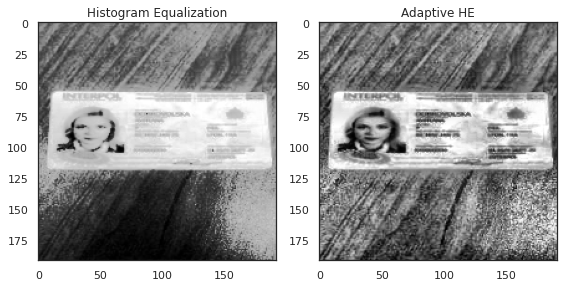

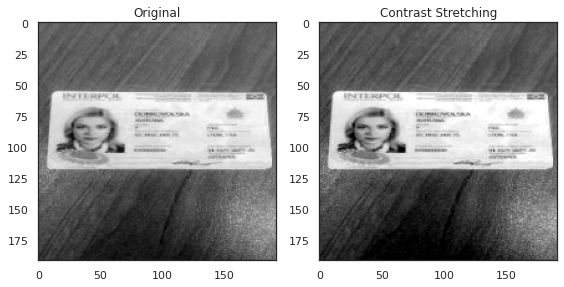

In [ ]:
img_cs = contrast_stretching(to_one_channel(img))

img_he = HE(to_one_channel(img))

img_ahe = AHE(to_one_channel(img))

plot_img1_vs_img2(img_he, img_ahe, "Histogram Equalization", "Adaptive HE")

plot_img1_vs_img2(to_one_channel(img), img_cs, "Original", "Contrast Stretching")

###Inspecting the transformations above visually suggests that contrast stretching helps to distinguish between the background and the id card better than in the original image. it also doesn't distorting the information on the ID like in case of Histogram Equalization(HE) and Adaptive HE.

###Therefore it looks like a good approach to apply as part of image preprocessing.

## Train-test split

Split the data into training and test set.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.IMAGE_FILENAME, df.TARGET, test_size=0.30, random_state=3, shuffle=True, stratify=df['TARGET'])

In [ ]:
df_train= df.loc[x_train.index.tolist()]
df_train.shape

(560, 6)

In [ ]:
def _oversample_positives(df, target):
    
    class_count = df[target].value_counts()

    print("Before oversampling: %s" % class_count)
    for i in range(1,len(class_count)):
        df_i = df[df[target] == i]
        oversampling_factor_i = class_count[0] / float(class_count[i])
        print(len(df_i))
        print("Oversampling factor for class %i: %s" %(i, str(oversampling_factor_i)))
    
        # Integer part of oversampling
        df = df.append(
            [df_i] * int(math.floor(oversampling_factor_i) - 1),
            ignore_index=False)
        # Float part of oversampling
        df = df.append(
            [df_i.sample(frac=oversampling_factor_i % 1)],
            ignore_index=False)
    
    print("After oversampling: %s" % df[target].value_counts())
    print("Shape after oversampling: %s" % str(df.shape))

    return df

In [ ]:
df_train_oversampled = _oversample_positives(df_train, "TARGET")

Before oversampling: 0    452
2     86
1     22
Name: TARGET, dtype: int64
22
Oversampling factor for class 1: 20.545454545454547
86
Oversampling factor for class 2: 5.255813953488372
After oversampling: 2    452
0    452
1    452
Name: TARGET, dtype: int64
Shape after oversampling: (1356, 6)


In [ ]:
x_train_oversampled = df_train_oversampled["IMAGE_FILENAME"]
y_train_oversampled = df_train_oversampled["TARGET"]

## Model



In [ ]:
def get_model():
   
    base_model = ResNet50(weights='imagenet',include_top=False,input_shape= (192, 192, 3) ) 

    add_model = Sequential()
    add_model.add(Flatten())
    add_model.add(Dense(256, activation='relu', input_dim=6 * 6 * 2048))
    add_model.add(Dropout(0.50))   
    add_model.add(Dense(128, activation='relu')) 
    add_model.add(Dropout(0.50))  
    add_model.add(Dense(64, activation='relu'))    
    add_model.add(Dense(3, activation='softmax'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    print(base_model.output)
    adam = keras.optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy',metrics=['acc'],
                  optimizer=adam)
    return model

In [ ]:
model = get_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv3_block2_add (Add)         (None, 24, 24, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 24, 24, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 24, 24, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 24, 24, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [ ]:
X_train_images = []
for file in x_train_oversampled:
    train_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    train_img = np.stack((train_img,)*3, axis=-1)
    train_img = contrast_stretching(train_img)
    X_train_images.append(train_img)
X_train_images = np.array(X_train_images)

In [ ]:
X_train_images.shape

(1356, 192, 192, 3)

In [ ]:
# converting to one-hot-encoding required by categorical_crossentropy loss
y_train_binary = to_categorical(y_train_oversampled)

In [ ]:
X_test_images = []
for file in x_test:
    test_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    test_img = np.stack((test_img,)*3, axis=-1)
    test_img = contrast_stretching(test_img)
    X_test_images.append(test_img)
X_test_images = np.array(X_test_images)

In [ ]:
datagen = ImageDataGenerator(rotation_range=4, width_shift_range=[-2, 2], height_shift_range=[-5, 5])

In [ ]:
model.fit_generator(datagen.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=7, shuffle=True)

<ipython-input-40-c53292118f8f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=7, shuffle=True)


Epoch 1/7
43/43 [==============================] - 757s 17s/step - loss: 2.2915 - acc: 0.6409
Epoch 2/7
43/43 [==============================] - 742s 17s/step - loss: 1.0878 - acc: 0.7780
Epoch 3/7
43/43 [==============================] - 744s 17s/step - loss: 0.3585 - acc: 0.8754
Epoch 4/7
43/43 [==============================] - 731s 17s/step - loss: 0.1541 - acc: 0.9535
Epoch 5/7
43/43 [==============================] - 734s 17s/step - loss: 0.3447 - acc: 0.9454
Epoch 6/7
43/43 [==============================] - 747s 17s/step - loss: 0.2534 - acc: 0.9285
Epoch 7/7
43/43 [==============================] - 752s 17s/step - loss: 0.2188 - acc: 0.9410


In [ ]:
predictions = model.predict(X_test_images)
predictions

8/8 [==============================] - 34s 4s/step


array([[0.2960645 , 0.28673357, 0.41720194],
       [0.36575556, 0.25582406, 0.3784203 ],
       [0.29809156, 0.29494783, 0.40696064],
       [0.28070092, 0.3340656 , 0.38523346],
       [0.32341585, 0.28796434, 0.38861975],
       [0.3543695 , 0.22676386, 0.41886666],
       [0.2631643 , 0.3700406 , 0.3667951 ],
       [0.22483654, 0.3152684 , 0.45989507],
       [0.21764259, 0.46789595, 0.31446147],
       [0.18468593, 0.49676496, 0.3185491 ],
       [0.2950662 , 0.2679589 , 0.43697485],
       [0.3159264 , 0.21024533, 0.47382832],
       [0.27326915, 0.3126962 , 0.41403472],
       [0.24232994, 0.39989552, 0.35777447],
       [0.2885704 , 0.31331566, 0.39811385],
       [0.33712426, 0.23883678, 0.42403886],
       [0.30583978, 0.30053106, 0.3936292 ],
       [0.30487692, 0.25835845, 0.43676457],
       [0.27036652, 0.23734497, 0.4922884 ],
       [0.31075662, 0.24345209, 0.44579124],
       [0.32518637, 0.25795177, 0.41686198],
       [0.2745347 , 0.27975824, 0.4457072 ],
       [0.

In [ ]:
#converting predictions to a single number
predictions_num = np.argmax(predictions, axis=1)
predictions_num

array([2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2])

In [ ]:
class_map = {2:"FULL_VISIBILITY", 1:"NO_VISIBILITY", 0:"PARTIAL_VISIBILITY"}
class_map[predictions_num[0]]

'FULL_VISIBILITY'

## Evaluation

In [ ]:
# Check AUC of the model
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_num, pos_label=2)
auc = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average=None)
f1_score_weighted = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average='weighted')
print("auc = %f" % auc)
print("f1_score_weighted = %s" % f1_score_weighted)
print("f1_score = %s" % f1_score)


auc = 0.436826
f1_score_weighted = 0.06183106878872308
f1_score = [0.03045685 0.05263158 0.22857143]


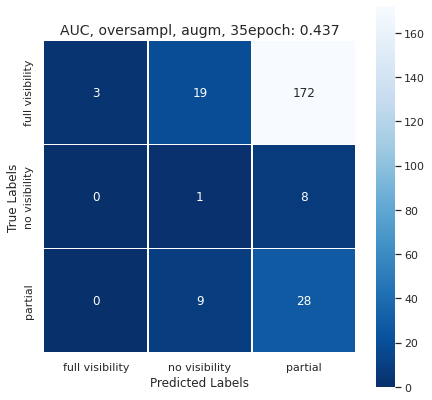

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions_num)

plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=12);
ax.set_ylabel('True Labels', size=12); 
ax.set_title('AUC, oversampl, augm, 35epoch: {:.3f}'.format(auc), size=14); 
ticklabels=['full visibility', 'no visibility', 'partial']
ax.xaxis.set_ticklabels(ticklabels); 
ax.yaxis.set_ticklabels(ticklabels);

The model is quite confident in predicting 

In [ ]:
df_prod_oversampled = _oversample_positives(df, "TARGET")
x_prod_oversampled = df_prod_oversampled["IMAGE_FILENAME"]
y_prod_oversampled = df_prod_oversampled["TARGET"]

Before oversampling: 0    646
2    123
1     31
Name: TARGET, dtype: int64
31
Oversampling factor for class 1: 20.838709677419356
123
Oversampling factor for class 2: 5.252032520325203
After oversampling: 0    646
2    646
1    646
Name: TARGET, dtype: int64
Shape after oversampling: (1938, 6)


In [ ]:
X_prod_images = []
for file in x_prod_oversampled:
    prod_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    prod_img = np.stack((prod_img,)*3, axis=-1)
    prod_img = contrast_stretching(prod_img)
    X_prod_images.append(prod_img)
X_prod_images = np.array(X_prod_images)

In [ ]:
y_prod_binary = to_categorical(y_prod_oversampled)

In [ ]:
model.fit_generator(datagen.flow(X_prod_images, y_prod_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

In [ ]:
# saving the model
model.save('prod_resnet50_oversampling_model.h5')  


##Model optimization:

---

## In this model i've use very less amount of CNN arichtecture used. 

## In future we've to use more CNN architecture for more validation score.

##Add early stopping to prevent overfitting.


##Create a Deep CNN architecture from scratch, train it on more epochs.